In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import re

# Load dataset efficiently
df = pd.read_csv("House_Rent_Dataset.csv", low_memory=False)

# Show essential data insights
print(df.dtypes)  # Display only column names and data types
print(df.isnull().sum())  # Check for missing values
print(df.head())  # Display the first few rows

Posted On            object
BHK                   int64
Rent                  int64
Size                  int64
Floor                object
Area Type            object
Area Locality        object
City                 object
Furnishing Status    object
Tenant Preferred     object
Bathroom              int64
Point of Contact     object
dtype: object
Posted On            0
BHK                  0
Rent                 0
Size                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64
    Posted On  BHK   Rent  Size            Floor    Area Type  \
0  18-05-2022    2  10000  1100  Ground out of 2   Super Area   
1  13-05-2022    2  20000   800       1 out of 3   Super Area   
2  16-05-2022    2  17000  1000       1 out of 3   Super Area   
3  04-07-2022    2  10000   800       1 out of 2   Super Area   
4  09-05-2022    2   7500   850     

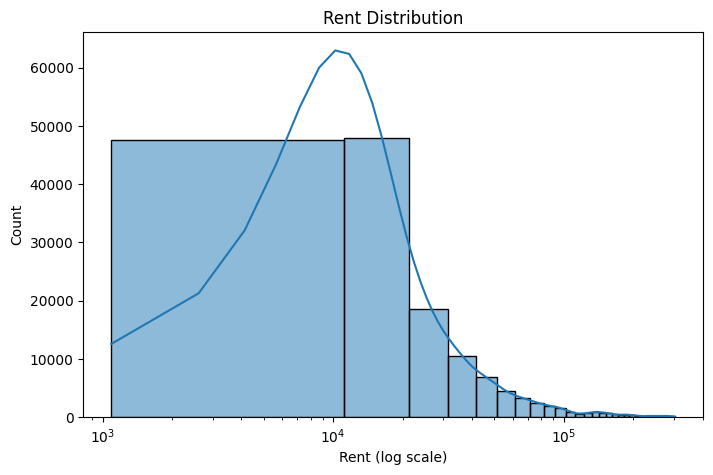

In [30]:
# Handle extreme rent values (optional)
df = df[df["Rent"] < df["Rent"].quantile(0.99)]  # Remove top 1% outliers

# Visualize rent distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["Rent"], bins=30, kde=True)  # Reduce bins for clarity
plt.xscale("log")  # Apply log scale to better visualize distribution
plt.xlabel("Rent (log scale)")
plt.ylabel("Count")
plt.title("Rent Distribution")
plt.show()


In [31]:
# Compute percentiles
low_threshold = df["Rent"].quantile(0.33)
high_threshold = df["Rent"].quantile(0.66)

# Convert to integer if necessary
low_threshold = int(low_threshold)
high_threshold = int(high_threshold)

# Print formatted thresholds
print(f"Low rent threshold: ₹{low_threshold:,}")   # ₹ for currency clarity
print(f"High rent threshold: ₹{high_threshold:,}")

Low rent threshold: ₹11,683
High rent threshold: ₹23,576


In [32]:
import numpy as np

# Compute thresholds & convert to integer
rent_low = int(df["Rent"].quantile(0.33))
rent_high = int(df["Rent"].quantile(0.66))

# Define conditions
conditions = [
    (df["Rent"] <= rent_low),
    (df["Rent"] <= rent_high),
    (df["Rent"] > rent_high)
]
categories = ["Low", "Medium", "High"]

# Assign rent categories using numpy (faster than apply)
df["Rent_Category"] = np.select(conditions, categories, default="High")

# Display category counts in order
print(df["Rent_Category"].value_counts().sort_index())


Rent_Category
High      52087
Low       50557
Medium    50557
Name: count, dtype: int64


In [33]:
# Drop columns safely, ignoring errors if a column is missing
df = df.drop(columns=["Posted On", "Rent", "Area Locality", "Point of Contact"], errors="ignore")

# Print remaining columns for verification
print("Remaining columns:", df.columns)


Remaining columns: Index(['BHK', 'Size', 'Floor', 'Area Type', 'City', 'Furnishing Status',
       'Tenant Preferred', 'Bathroom', 'Rent_Category'],
      dtype='object')


In [34]:
def get_floor_number(floor):
    if pd.isna(floor):  # Handle NaN values
        return 0
    floor = floor.lower()  # Convert to lowercase for consistency
    if "ground" in floor:
        return 0  # Ensure "Ground" is correctly mapped
    match = re.search(r'\d+', floor)
    return int(match.group()) if match else 0  # Extract number, default to 0

df["Floor"] = df["Floor"].astype(str).apply(get_floor_number)

# Check if it worked
print(df[["Floor"]].head())


   Floor
0      0
1      1
2      1
3      1
4      1


In [35]:
# Fill missing values with a placeholder (if necessary)
df[["Area Type", "City", "Furnishing Status", "Tenant Preferred"]] = df[
    ["Area Type", "City", "Furnishing Status", "Tenant Preferred"]
].fillna("Unknown")

# One-Hot Encoding
df = pd.get_dummies(df, columns=["Area Type", "City", "Furnishing Status", "Tenant Preferred"], drop_first=True)

# Ensure consistent column names (removes spaces/special characters)
df.columns = df.columns.str.replace(" ", "_").str.replace("-", "_")

# Display the updated DataFrame
print(df.head())


   BHK  Size  Floor  Bathroom Rent_Category  Area_Type_Carpet_Area  \
0    2  1100      0         2           Low                  False   
1    2   800      1         1        Medium                  False   
2    2  1000      1         1        Medium                  False   
3    2   800      1         1           Low                  False   
4    2   850      1         1           Low                   True   

   Area_Type_Super_Area  City_Chennai  City_Delhi  City_Hyderabad  \
0                  True         False       False           False   
1                  True         False       False           False   
2                  True         False       False           False   
3                  True         False       False           False   
4                 False         False       False           False   

   City_Kolkata  City_Mumbai  Furnishing_Status_Semi_Furnished  \
0          True        False                             False   
1          True        False    

In [36]:
from sklearn.preprocessing import LabelEncoder

# Encode Rent_Category as numerical labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["Rent_Category"])  # Converts ['Low', 'Medium', 'High'] → [0,1,2]

# Split into training and testing sets
X = df.drop(columns=["Rent_Category"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Check class distribution
print("Training Set Class Distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Testing Set Class Distribution:\n", pd.Series(y_test).value_counts(normalize=True))

# Verify shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


Training Set Class Distribution:
 0    0.339989
2    0.330010
1    0.330002
Name: proportion, dtype: float64
Testing Set Class Distribution:
 0    0.340002
1    0.330015
2    0.329983
Name: proportion, dtype: float64
X_train shape: (122560, 15)
X_test shape: (30641, 15)
y_train shape: (122560,)
y_test shape: (30641,)


In [37]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler

# Scale the feature data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model with scaled data
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train_scaled, y_train)
print("Logistic Regression Accuracy (Scaled):", model.score(X_test_scaled, y_test))

# Train a Random Forest model (no scaling needed)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
print("Random Forest Accuracy:", rf_model.score(X_test, y_test))


Logistic Regression Accuracy (Scaled): 0.7332332495675729
Random Forest Accuracy: 0.799614895075226


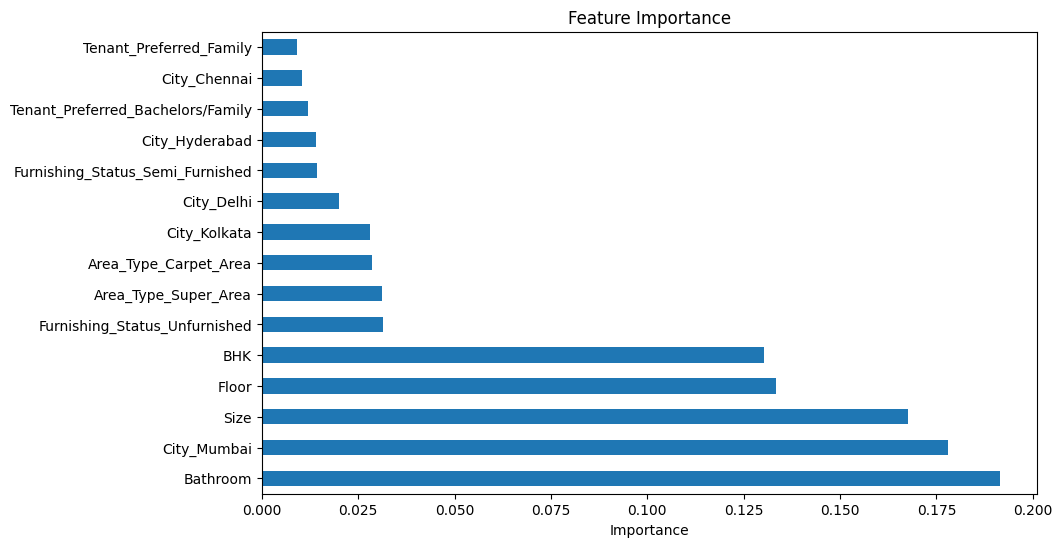


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88     10418
           1       0.81      0.79      0.80     10112
           2       0.69      0.74      0.72     10111

    accuracy                           0.80     30641
   macro avg       0.80      0.80      0.80     30641
weighted avg       0.80      0.80      0.80     30641
 



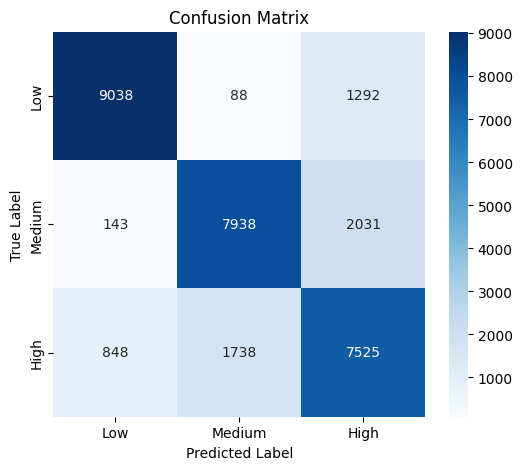

In [38]:
# Feature Importance (Random Forest)
feat_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feat_importances.sort_values(ascending=False).plot(kind='barh', figsize=(10, 6))
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

# Evaluate the Random Forest model
y_pred = rf_model.predict(X_test)

# Display Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred), "\n")

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
